# Example of Evaluating Performance of Alternative Modeling Approaches

In [3]:
# imports
import os
import numpy as np
import pandas as pd
import random
import datetime
import subprocess
import math
import pickle
from tqdm.notebook import tqdm
import anndata
import scanpy as sc
from datasets import load_from_disk

# visualization
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix

seed_num=0

In [4]:
# cpu cores
num_proc = 16

# training dataset size
subsample_size = 10_000

# Load Token Dictionary

In [ ]:
# load gene_ensembl_id:token dictionary
with open("/path/to/token_dictionary.pkl", "rb") as fp:
    token_dictionary = pickle.load(fp)
token_gene_dict = {v: k for k,v in token_dictionary.items()}

# Load Training Data and Classes

In [12]:
# prepare targets and labels
def prep_inputs(genegroup1, genegroup2, balance):

    targets1 = [gene for gene in genegroup1 if gene in token_dictionary]
    targets2 = [gene for gene in genegroup2 if gene in token_dictionary]
    
    if balance == "balance":
        min_sample = min(len(targets1), len(targets2))
        random.seed(seed_num)
        targets1 = random.sample(targets1, min_sample)
        random.seed(seed_num)
        targets2 = random.sample(targets2, min_sample)

    targets1_id = [token_dictionary[gene] for gene in targets1]
    targets2_id = [token_dictionary[gene] for gene in targets2]
    
    targets = np.array(targets1_id + targets2_id)
    labels = np.array([0]*len(targets1_id) + [1]*len(targets2_id))
    nsplits = min(5, min(len(targets1_id), len(targets2_id))-1)
    assert nsplits > 2
    print(f"# targets1: {len(targets1_id)}\n# targets2: {len(targets2_id)}\n# splits: {nsplits}")
    return targets, labels, nsplits

In [13]:
# load training labels for dosage sensitive vs. insensitive TFs (format: Ensembl IDs)
dosage_tfs = pd.read_csv("/path/to/dosage_sens_tfs.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
targets, labels, nsplits = prep_inputs(sensitive, insensitive, "balance")

# targets1: 122
# targets2: 122
# splits: 5


In [14]:
# load training dataset
train_dataset=load_from_disk("/path/to/genecorpus_30M_2048.dataset")

In [ ]:
shuffled_train_dataset = train_dataset.shuffle(seed=42)

In [16]:
# reduce training dataset to 5x subsample size (to leave room for further filtering for cells that express target genes)
subsampled_training_dataset = shuffled_train_dataset.select([i for i in range(subsample_size*5)])

In [ ]:
def if_contains_target(example):
    a = targets
    b = example['input_ids']
    return not set(a).isdisjoint(b)

# filter dataset for cells that express target genes
data_w_target = subsampled_training_dataset.filter(if_contains_target, num_proc=num_proc)

In [19]:
# subsample data to desired number of training examples
data_subsample = data_w_target.select([i for i in range(subsample_size)])

In [ ]:
def get_ranks(example):
    example_rank_dict = dict(zip(example["input_ids"],[2048-i for i in range(example["length"])]))
    target_vector = [example_rank_dict.get(target,0) for target in targets]
    example["target_vector"] = target_vector
    return example

# get ranks of target genes within training cells for rank-based trials
data_w_target_vectors = data_subsample.map(get_ranks, num_proc=num_proc)
target_arr = np.transpose(np.array(data_w_target_vectors["target_vector"]))

# Cross-Validate Token Classifier

In [23]:
# functions to evaluate classifier

def classifier_predict(model_type, model, eval_arr, labels_eval, mean_fpr):
    y_pred = model.predict(eval_arr)
    y_true = labels_eval
    conf_mat = confusion_matrix(y_true, y_pred)
    # probability of class 1
    if model_type == "SVM":
        y_prob = model.decision_function(eval_arr)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
    else:
        y_prob = model.predict_proba(eval_arr)
        fpr, tpr, _ = roc_curve(y_true, y_prob[:,1])
    # plot roc_curve for this split
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    # interpolate to graph
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return fpr, tpr, interp_tpr, conf_mat 

# get cross-validated AUC mean and sd metrics
def get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt):
    wts = [count/sum(all_tpr_wt) for count in all_tpr_wt]
    print(wts)
    all_weighted_tpr = [a*b for a,b in zip(all_tpr, wts)]
    mean_tpr = np.sum(all_weighted_tpr, axis=0)
    mean_tpr[-1] = 1.0
    all_weighted_roc_auc = [a*b for a,b in zip(all_roc_auc, wts)]
    roc_auc = np.sum(all_weighted_roc_auc)
    roc_auc_sd = math.sqrt(np.average((all_roc_auc-roc_auc)**2, weights=wts))
    return mean_tpr, roc_auc, roc_auc_sd

In [24]:
# cross-validate token classifier
def cross_validate(model_type, model, target_arr, labels, nsplits, subsample_size, num_proc):
    print(f"# training cells: {target_arr.shape[1]}")
    
    # initiate eval metrics to return
    num_classes = len(set(labels))
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    all_roc_auc = []
    all_tpr_wt = []
    confusion = np.zeros((num_classes,num_classes))
    
    # set up cross-validation splits
    skf = StratifiedKFold(n_splits=nsplits, random_state=0, shuffle=True)
    # train and evaluate
    iteration_num = 0
    for train_index, eval_index in tqdm(skf.split(target_arr, labels)):

        print(f"****** Crossval split: {iteration_num}/{nsplits-1} ******\n")
        # generate cross-validation splits
        targets_train, targets_eval = target_arr[train_index], target_arr[eval_index]
        labels_train, labels_eval = labels[train_index], labels[eval_index]
        
        model = model
    
        # train the token classifier
        model.fit(targets_train, labels_train)

        # evaluate model
        fpr, tpr, interp_tpr, conf_mat = classifier_predict(model_type, model, targets_eval, labels_eval, mean_fpr)

        # append to tpr and roc lists
        confusion = confusion + conf_mat
        all_tpr.append(interp_tpr)
        all_roc_auc.append(auc(fpr, tpr))
        # append number of eval examples by which to weight tpr in averaged graphs
        all_tpr_wt.append(len(tpr))
        
        iteration_num = iteration_num + 1
        
    # get overall metrics for cross-validation
    mean_tpr, roc_auc, roc_auc_sd = get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt)
    return all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion

In [25]:
# plot ROC curve
def plot_ROC(bundled_data, title):
    fig = plt.figure()
    fig.set_size_inches(17, 10.5)
    plt.rcParams.update({'font.size': 20})
    lw = 4
    for roc_auc, roc_auc_sd, mean_fpr, mean_tpr, sample, color, linestyle in bundled_data:
        plt.plot(mean_fpr, mean_tpr, color=color,
                 lw=lw, label="{0} (AUC {1:0.2f} $\pm$ {2:0.2f})".format(sample, roc_auc, roc_auc_sd), linestyle=linestyle)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

## Random Forest - Ranks

In [ ]:
# cross-validate token classifier
model = RandomForestClassifier(max_depth=2, random_state=0)
all_roc_auc0, roc_auc0, roc_auc_sd0, mean_fpr0, mean_tpr0, confusion0 \
    = cross_validate("RF", model, target_arr, labels, nsplits, subsample_size, 1)

## Logistic Regression - Ranks

In [ ]:
# cross-validate token classifier
model = LogisticRegression(random_state=0)
all_roc_auc1, roc_auc1, roc_auc_sd1, mean_fpr1, mean_tpr1, confusion1 \
    = cross_validate("LR", model, target_arr, labels, nsplits, subsample_size, 1)

## SVM - Ranks

In [ ]:
# cross-validate token classifier
model = SVC(random_state=0)
all_roc_auc2, roc_auc2, roc_auc_sd2, mean_fpr2, mean_tpr2, confusion2 \
    = cross_validate("SVM", model, target_arr, labels, nsplits, subsample_size, 1)

# Classifiers Using Counts

In [ ]:
rootdir = "/path/to/count_data/"

adata_list = []

for subdir, dirs, files in os.walk(rootdir):	
    for file in files:
        if file.endswith(".loom"):
            print(f"{rootdir}{file}")
            adata = anndata.read_loom(f"{rootdir}{file}")
            adata_list += [adata]

In [35]:
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum=1e4)

In [36]:
targets_ensembl = np.array([token_gene_dict[target] for target in targets])

In [37]:
target_arr = []
for target in targets_ensembl:
    target_vectors = np.zeros((0,0))
    for adata in adata_list:
        if target in list(adata.var["ensembl_id"]):
            target_vectors = np.append(target_vectors, np.array(adata[:,adata.var.ensembl_id == target].X.todense()))
        else:
            target_vectors = np.append(target_vectors, np.array([0]*adata.shape[0]))
    target_arr += [np.transpose(target_vectors)]

In [38]:
target_arr = np.array(target_arr)

In [ ]:
idx = np.argwhere(np.all(target_arr[..., :] == 0, axis=0))
target_arr = np.delete(target_arr, idx, axis=1)

In [40]:
random_indices = np.random.choice(target_arr.shape[1], size=10_000, replace=False)

In [41]:
target_arr = target_arr[:,random_indices]

## SVM - Counts

In [ ]:
# cross-validate token classifier
model = SVC(random_state=0)
all_roc_auc20, roc_auc20, roc_auc_sd20, mean_fpr20, mean_tpr20, confusion20 \
    = cross_validate("SVM", model, target_arr, labels, nsplits, subsample_size, 1)

## Random Forest - Counts

In [ ]:
# cross-validate token classifier
model = RandomForestClassifier(max_depth=2, random_state=0)
all_roc_auc00, roc_auc00, roc_auc_sd00, mean_fpr00, mean_tpr00, confusion00 \
    = cross_validate("RF", model, target_arr, labels, nsplits, subsample_size, 1)

## Logistic Regression - Counts

In [ ]:
# cross-validate token classifier
model = LogisticRegression(random_state=0)
all_roc_auc10, roc_auc10, roc_auc_sd10, mean_fpr10, mean_tpr10, confusion10 \
    = cross_validate("LR", model, target_arr, labels, nsplits, subsample_size, 1)

In [61]:
# bundle data for plotting
bundled_data = []
bundled_data += [(roc_auc2, roc_auc_sd2, mean_fpr2, mean_tpr2, "SVM rank", "purple", "solid")]
bundled_data += [(roc_auc0, roc_auc_sd0, mean_fpr0, mean_tpr0, "Random Forest rank", "blue", "solid")]
bundled_data += [(roc_auc1, roc_auc_sd1, mean_fpr1, mean_tpr1, "Logistic Regression rank", "green", "solid")]
bundled_data += [(roc_auc20, roc_auc_sd20, mean_fpr20, mean_tpr20, "SVM counts", "purple", "dashed")]
bundled_data += [(roc_auc00, roc_auc_sd00, mean_fpr00, mean_tpr00, "Random Forest counts", "blue", "dashed")]
bundled_data += [(roc_auc10, roc_auc_sd10, mean_fpr10, mean_tpr10, "Logistic Regression counts", "green", "dashed")]

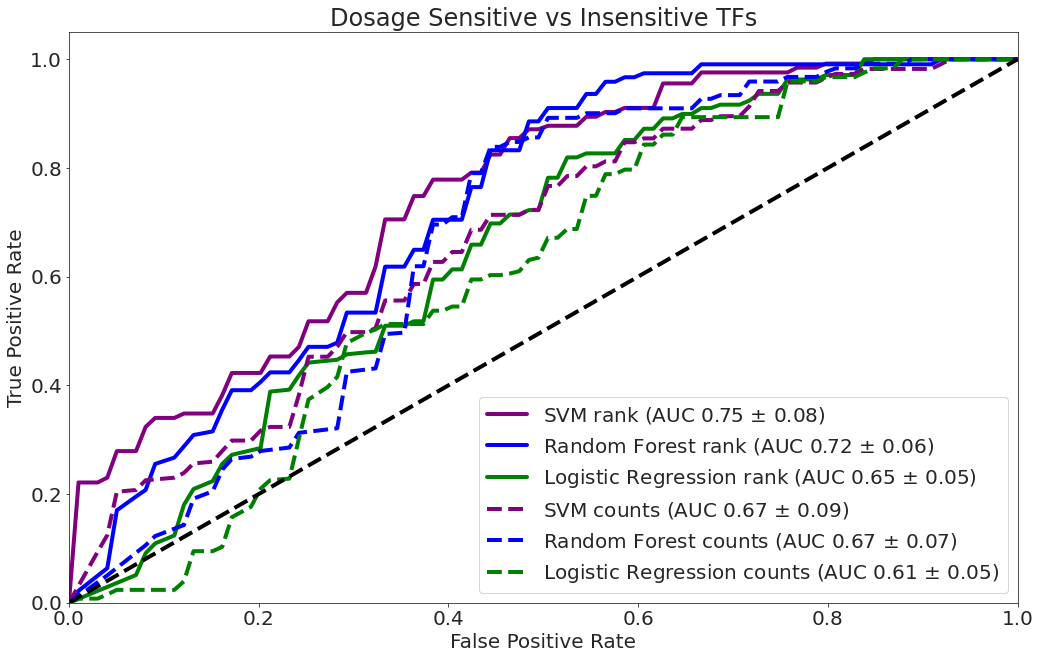

In [62]:
# plot ROC
plot_ROC(bundled_data, 'Dosage Sensitive vs Insensitive TFs')

# Save Results

In [63]:
# create output directory
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
training_output_dir = f"/path/to/output_dir/{datestamp}_alternativeTokenClassifier_dosageTF_n{subsample_size}/"

# make training and model output directories
subprocess.call(f'mkdir {training_output_dir}', shell=True)

1

In [74]:
with open(os.path.join(training_output_dir, f"bundled_data.pickle"), "wb") as fp:
     pickle.dump(bundled_data, fp)

In [66]:
with open(os.path.join(training_output_dir, f"confusion_RF_ranks.pickle"), "wb") as fp:
     pickle.dump(confusion0, fp)

In [67]:
with open(os.path.join(training_output_dir, f"confusion_LogReg_ranks.pickle"), "wb") as fp:
     pickle.dump(confusion1, fp)

In [68]:
with open(os.path.join(training_output_dir, f"confusion_SVM_ranks.pickle"), "wb") as fp:
     pickle.dump(confusion2, fp)

In [69]:
with open(os.path.join(training_output_dir, f"confusion_RF_counts.pickle"), "wb") as fp:
     pickle.dump(confusion00, fp)

In [70]:
with open(os.path.join(training_output_dir, f"confusion_LogReg_counts.pickle"), "wb") as fp:
     pickle.dump(confusion10, fp)

In [71]:
with open(os.path.join(training_output_dir, f"confusion_SVM_counts.pickle"), "wb") as fp:
     pickle.dump(confusion20, fp)